In [0]:
%sql
SELECT * FROM salaries LIMIT 10;


work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M
2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M
2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M
2023,SE,FT,Machine Learning Engineer,132300,USD,132300,US,0,US,M
2023,MI,FT,Data Specialist,90000,USD,90000,US,0,US,M
2023,MI,FT,Data Specialist,80000,USD,80000,US,0,US,M
2023,SE,FT,Machine Learning Engineer,212000,USD,212000,US,0,US,M
2023,SE,FT,Machine Learning Engineer,93300,USD,93300,US,0,US,M


In [0]:
%sql
SELECT 
    MIN(salary_in_usd) AS Min_Salary,
    MAX(salary_in_usd) AS Max_Salary,
    AVG(salary_in_usd) AS Avg_Salary,
    STDDEV(salary_in_usd) AS Std_Dev_Salary
FROM salaries;


Min_Salary,Max_Salary,Avg_Salary,Std_Dev_Salary
15000,615201,149488.26564452017,64222.105058392546


1. Setup and Configuration

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Salary Data Analysis") \
    .getOrCreate()



2. Data Extraction

In [0]:
# Read data from Delta Lake into a DataFrame
df = spark.read.format("delta").load("dbfs:/user/hive/warehouse/salaries")

3. Data Transformation Focusing on Entry-Level Experience

In [0]:
# Filter the DataFrame to include only entry-level ('EN') records
df_entry_level = df.filter(col("experience_level") == 'EN')

4. Data Loading

In [0]:
from delta.tables import *
import os

table_path = "dbfs:/user/hive/warehouse/salaries_entry_level"

if DeltaTable.isDeltaTable(spark, table_path):
    # Load the existing Delta table to a DataFrame
    df_entry_level_table = spark.read.format("delta").load(table_path)

    # Merge existing & new data
    df_entry_level_union = df_entry_level_table.union(df_entry_level)

    # Write back to table, ensuring it's registered in the Spark SQL catalog
    df_entry_level_union.write.format("delta").mode("overwrite").option("path", table_path).saveAsTable("salaries_entry_level")

else:
    # Save the DataFrame as a new Delta table
    df_entry_level.write.format("delta").mode("overwrite").option("path", table_path).saveAsTable("salaries_entry_level")


5. Data Validation Checks

In [0]:
# Example validation: Checking for null values in salary_in_usd
null_salary_count = df_entry_level.filter(col("salary_in_usd").isNull()).count()
print(f"Number of records with null salary: {null_salary_count}")
df_entry_level.show()

Number of records with null salary: 0
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              EN|             FL|Business Intellig...|500000|            GBP|       615201|                IN|         100|              IN|           S|
|     2023|              EN|             FT|     BI Data Analyst| 25000|            USD|        25000|                UA|         100|              NL|           M|
|     2023|              EN|             FT|        Data Analyst|109900|            USD|       109900|                US|           0|   

6. Data Analysis using Spark SQL

In [0]:
# Register the DataFrame as a SQL temporary view
df_entry_level.createOrReplaceTempView("entry_level_salaries")

# Example query: Average entry-level salary by country
avg_salary_by_country = spark.sql("""
    SELECT employee_residence, AVG(salary_in_usd) AS avg_salary
    FROM entry_level_salaries
    GROUP BY employee_residence
""")
avg_salary_by_country.show()


+------------------+------------------+
|employee_residence|        avg_salary|
+------------------+------------------+
|                DZ|          100000.0|
|                UA|           37500.0|
|                NL|           51370.2|
|                PL|           18160.0|
|                CN|          125404.0|
|                AT|           50000.0|
|                RU|           16455.0|
|                IQ|          100000.0|
|                HR|           35000.0|
|                PT|24271.333333333332|
|                CL|          105000.0|
|                ID|           15000.0|
|                AU|          78799.75|
|                PK|           42043.4|
|                CA|  78753.4705882353|
|                UZ|           70000.0|
|                GB| 64752.22222222222|
|                BR|           19910.0|
|                DE|         66326.125|
|                EC|           16000.0|
+------------------+------------------+
only showing top 20 rows



7. Data Preparation for salary comparison

In [0]:
# Aggregate data to find the average salary for different job titles in the US and GB
avg_salary_job_title = spark.sql("""
    SELECT job_title, employee_residence, AVG(salary_in_usd) AS avg_salary
    FROM entry_level_salaries
    WHERE employee_residence IN ('US', 'GB')
    GROUP BY job_title, employee_residence
    ORDER BY job_title, employee_residence
""")
avg_salary_job_title.show()


+--------------------+------------------+-----------------+
|           job_title|employee_residence|       avg_salary|
+--------------------+------------------+-----------------+
|        AI Developer|                US|         130000.0|
|AI Research Engineer|                GB|          36940.0|
|        AI Scientist|                US|          50000.0|
|  Analytics Engineer|                US|         115930.0|
|Applied Data Scie...|                GB|         110037.0|
|   Applied Scientist|                US|         178367.5|
|          BI Analyst|                US|          76000.0|
|     BI Data Analyst|                US|          56000.0|
|    BI Data Engineer|                US|          60000.0|
|        BI Developer|                US|         100650.0|
|   Big Data Engineer|                US|          70000.0|
|Business Data Ana...|                US|          74000.0|
|Business Intellig...|                US|          61450.0|
|Business Intellig...|                US

7. Data Visualization

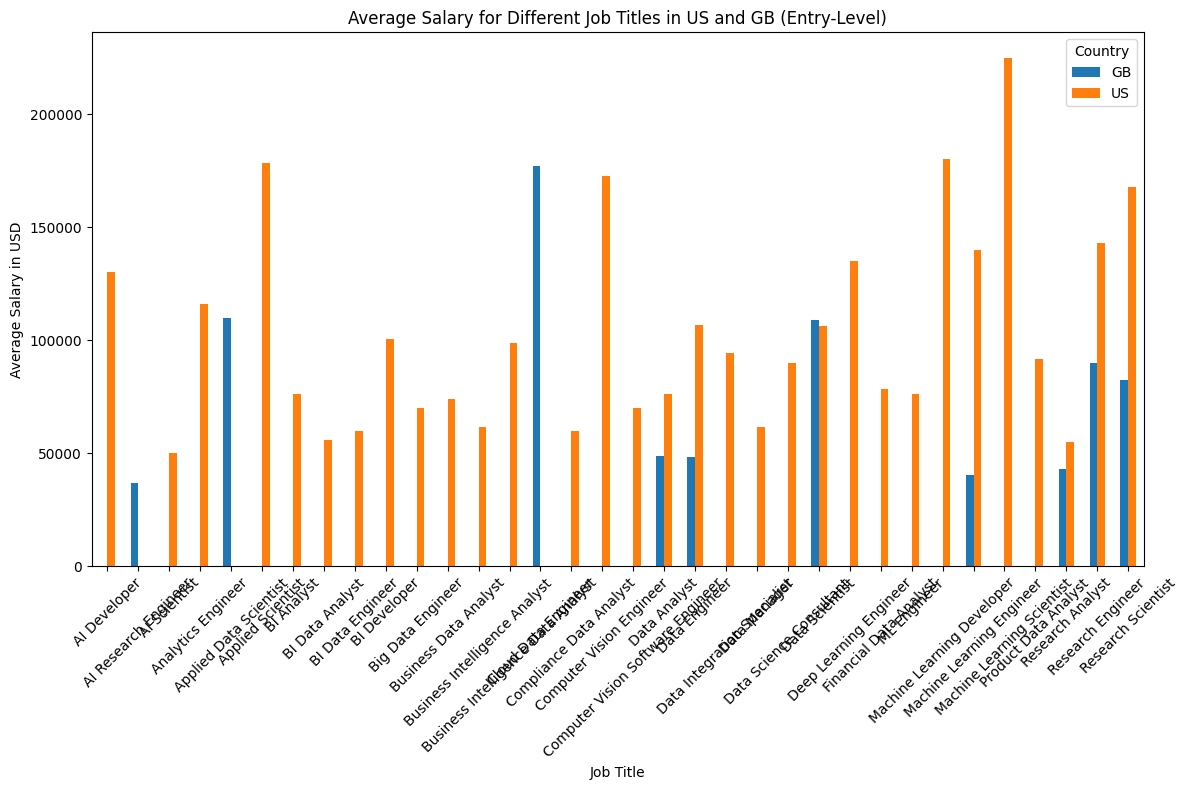

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
avg_salary_pd = avg_salary_job_title.toPandas()

# Pivot the DataFrame to get a better structure for plotting
pivot_df = avg_salary_pd.pivot(index='job_title', columns='employee_residence', values='avg_salary')

# Plotting
plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', ax=plt.gca())
plt.title('Average Salary for Different Job Titles in US and GB (Entry-Level)')
plt.xlabel('Job Title')
plt.ylabel('Average Salary in USD')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.tight_layout()
plt.show()
